In [12]:
import torch
from torch import nn
from collections import deque
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import os

from game import BlackJack
from model import Blackjack_DQNet

In [13]:
# Create the directory to store the model
model_folder_path = "./model"
if not os.path.exists(model_folder_path):
    os.makedirs(model_folder_path)
MODEL_PATH = os.path.join(model_folder_path, "model.pth")

In [14]:
MAX_MEMORY = 1_000_000
BATCH_SIZE = 1000
LR = 0.001

In [15]:
plt.ion()

def plot(scores, mean_scores):
    display.clear_output(wait = True)
    display.display(plt.gcf())
    plt.clf()
    plt.title("Training")
    plt.xlabel("Number of Games")
    plt.ylabel("Score")
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin = -500)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))

In [16]:
class QTrainer:
    def __init__(self, model, learning_rate, gamma):
        self.lr = learning_rate
        self.gamma = gamma
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype = torch.float)
        next_state = torch.tensor(next_state, dtype = torch.float)
        action = torch.tensor(action, dtype= torch.float)
        reward = torch.tensor(reward, dtype = torch.float)

        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done,)
        
        pred = self.model(state)
        target = pred.clone()
        # print("Target",target)
        # print("Done", done)
        for i in range(len(done)):
            Q_new = reward[i]
            if not done[i]:
                Q_new = reward[i] + self.gamma * torch.max(self.model(next_state[i]))
            target[i][torch.argmax(action).item()] = Q_new

        # Q_new = r + y*max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        loss = self.criterion(target, pred)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [17]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # Parameters to control randomness
        self.gamma = 0.9 # Discount rate is less than 1
        self.memory = deque(maxlen = MAX_MEMORY) # popleft()
        self.model = Blackjack_DQNet(2,128,2) # 2 state values, 2 different actions, play around with hidden size
        self.trainer = QTrainer(self.model, learning_rate = LR, gamma = self.gamma)


    def get_state(self, game):
        return game.get_state()
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # Returns a list of tuples 
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        # print("Actions",actions)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
    
    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # Random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 1)
            final_move[move] = 1
        else:
            state_0 = torch.tensor(state, dtype = torch.float)
            prediction = self.model(state_0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

In [18]:
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    score = 0
    agent = Agent()
    num_decks = 1
    game = BlackJack(num_decks)
    while True:
        # Get old state
        state_old = agent.get_state(game)
        # print(state_old)
        # Get move
        final_move = agent.get_action(state_old)
        # print(final_move)
        action_list = ["Hit", "Stand"]
        action_move = action_list[np.argmax(final_move)]
        # Perform move and get new state
        state_new, reward, done = game.step(action_move)
        # Train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # Remember 
        agent.remember(state_old, final_move, reward, state_new, done)
        score += reward
        if done:
            # print("DONE")
            # Train the long memory, plot results
            game.reset(num_decks)
            agent.n_games += 1
            agent.train_long_memory()
            # print(f"Game {agent.n_games} | Score: {score} | Record {record}")

            if score > record:
                record = score
                torch.save(agent.model.state_dict(), MODEL_PATH)

            print(f"Game {agent.n_games} | Score: {score} | Record {record}")

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)

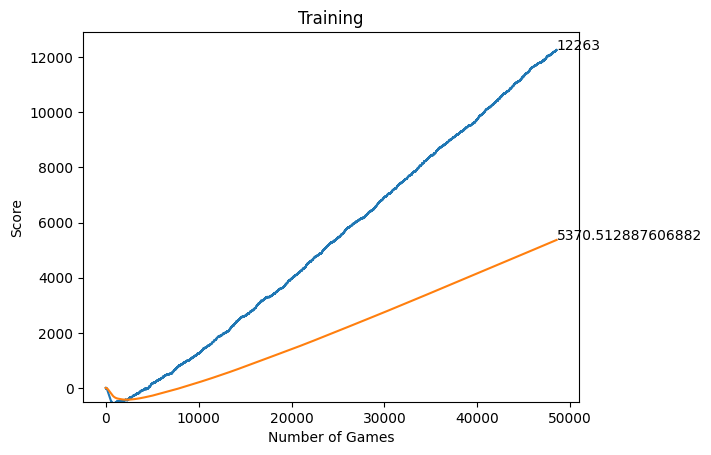

KeyboardInterrupt: 

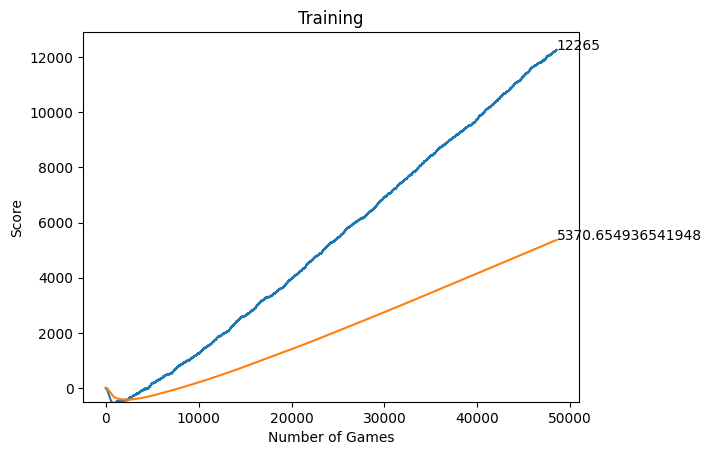

In [19]:
train()